# Example Notebook #1
In this notebook the problem we would like to solve is that given a set of instruments that are intertemporally independent, we want to construct a portfolio based on a weighing scheme that guides the allocation process. After conducting this simple test, we would like to evaluate the results based on standard measures of risk and performance, benchmark it to our chosen instrument and conduct a simple risk attribution using a user defined cross-sectional factor model.

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
%load_ext autoreload
%autoreload 2
plt.style.use('bmh')

In [2]:
from portfolio_swissknife import portfolio as ps
from portfolio_swissknife import risk_model as rm

## 1. Loading Data and Setup
- We first load the data using the `Portfolio` class and it's associated method `get_prices`. The analysis is restricted by a period required to be set by `set_period`. 

In [3]:
sectors = ['XLK', 'XLY', 'XLB', 'XLC', 'XLE', 'XLU', 'XLF', 'XLV', 'XOP']
random_stocks = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
                 'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',]

pf1 = ps.Portfolio(random_stocks)
pf1.set_period(('2012-01-01', '2021-05-28'))
pf1.get_prices('daily')

[*********************100%***********************]  16 of 16 completed


In [4]:
pf1.set_benchmark('SPY')
pf1.set_discount('^TNX')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## 2. Performing a Historical Backtest With Fixed Assets

Then we set the constraints using `set_constraints` and conduct a historical backtest. This will store backtest results in the `Portfolio` class based on the frequency of the rebalance (in trading days), it's estimation period (in trading days) and the model selected in the `models: list`. The supported models are:
 - Equal Weights (EW)
 - Global Minimum Variance (GMV)
 - Equal Risk Contribution (RP)
 - Maximum Diversification Ratio (MDR)
 - Maximum Sharpe Ratio (MSR)
 - Minimum Expected Shortfall (MES)
 - Minimum Maximum Drawdown (MDD)

To be added:
 - Minimum Skew (MS)
 - Hierarchical Risk Parity (HRP)
 
We can also select an estimation method currently supported for the first and second moment with a custom function or a function from the built-in estimation methods. 
Currently supported estimation methods are:
 - EMA (1st moment)
 - Elton Gruber (2nd moment)
 - Shrinkage wrapper (2nd moment)

In [5]:
#TODO FIX SHRINKAGE
# pf1.set_estimation_method(est.ema_return_historic, moment = 1)
# pf1.set_estimation_method(est.elton_gruber_cov, moment = 2)

In [6]:
pf1.set_constraints(default=True) #defaults to long_only fully invested portfolio with no leverage
pf1.historical_backtest(models=['EW','RP', 'GMV', 'MDD', 'MDR'], frequency=22, estimation_period = int(252*1.5))

<AxesSubplot:title={'center':'Optimization runtime'}>

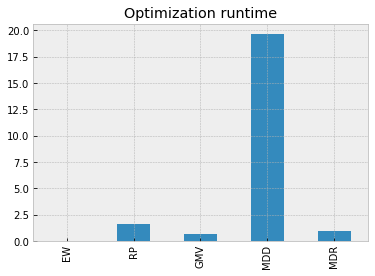

In [7]:
#runtimes
pd.DataFrame(pf1.backtest).loc['opt_time'].plot(kind='bar', title='Optimization runtime')

In [13]:
pf1.backtest['EW']['returns'].shape

(1987, 1)

,EW,RP,GMV,MDD,MDR
Average Returns,15.58%,13.23%,10.99%,14.78%,11.94%
CAGR,15.05%,12.77%,10.37%,14.42%,11.18%
Volatility,39.46%,36.38%,33.16%,38.45%,34.56%
Max DD,38.39%,31.80%,31.34%,30.94%,35.67%
Skewness,-0.59,-0.39,-0.63,-0.46,-0.79
Kurtosis,-3.00,-3.00,-2.99,-3.00,-3.00
Sharpe Ratio,0.34,0.31,0.27,0.33,0.29
Sortino Ratio,0.94,0.88,0.73,0.98,0.75
Calmar Ratio,-0.41,-0.42,-0.35,-0.48,-0.33
Pain Ratio,420.40,396.58,318.67,363.18,286.26


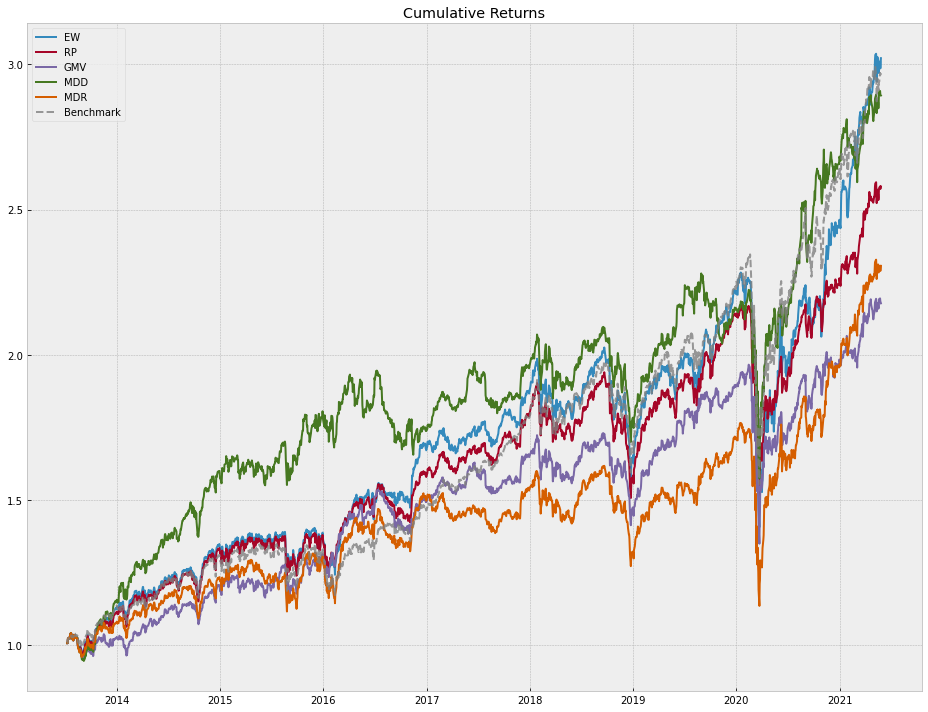

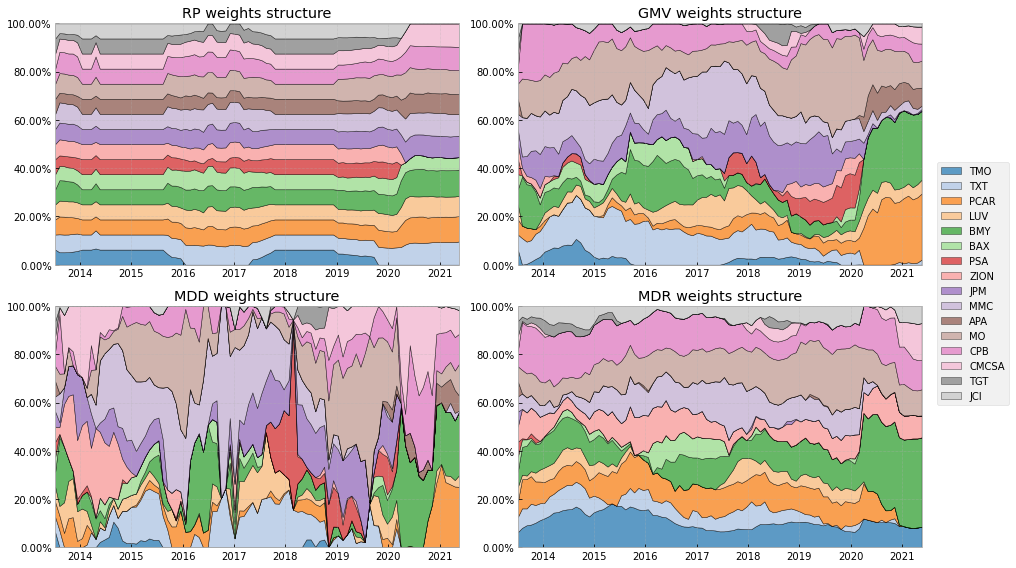

In [8]:
pf1.get_backtest_report(num_rows=2)

## 3. Performing Risk Attribution
- After we backtested some weighting schemes we would like to decompose the risk. This can be done using the object `RiskModel` which provides the methods `rolling_backtest` to conduct a rolling estimation of a pre-specified factor model. The results can then be visualized through `get_risk_report` or further accesed within the object.

In [9]:
factors = ['SPY', 'VLUE', 'SIZE', 'QUAL', 'MTUM', 'USMV']
rm1 = rm.RiskModel(pf1, factors)
rm1.get_prices('daily')

[*********************100%***********************]  6 of 6 completed


In [10]:
rm1.rolling_factor_exposure(method='linear')

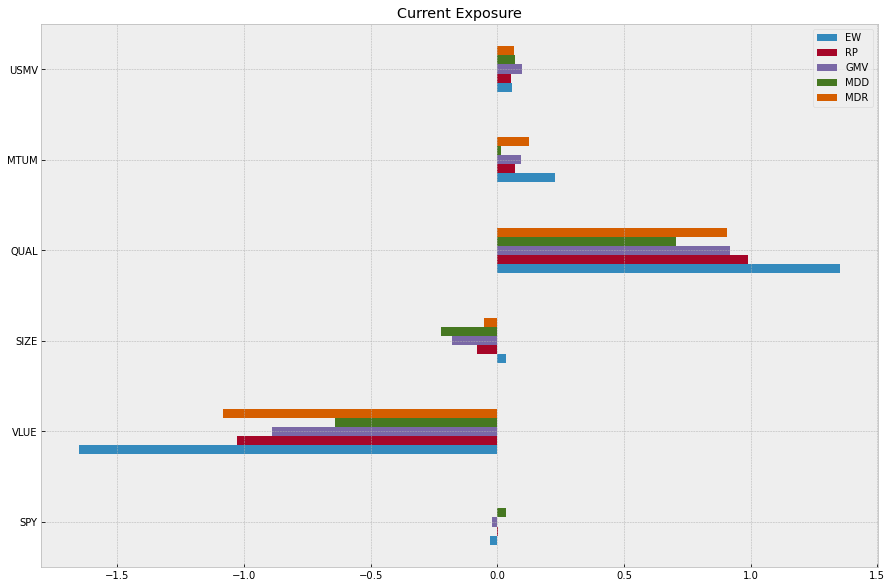

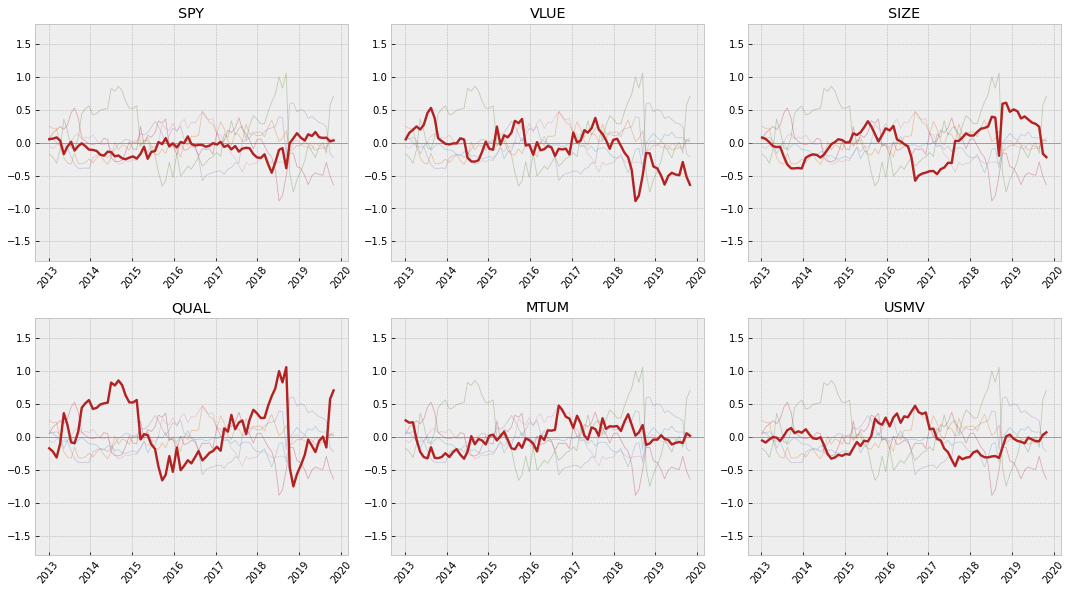

In [11]:
rm1.get_risk_report(model = 'MDD')